test multi-task optimisation in 4D

use branch `multi-task` to run this notebook!

In [1]:
import numpy as np
from boss.bo.bo_main import BOMain

In [2]:
import matplotlib.pyplot as plt

In [3]:
seed=0

utilities:

In [4]:
import GPy

In [5]:
def load_model(filename):

    # load saved data
    saved=np.load(filename)
    dim=saved['X'].shape[1]

    # create kernel
    k=GPy.kern.StdPeriodic(input_dim=dim,ARD1=True,ARD2=True)

    # create mean function
    mf=GPy.mappings.Constant(dim,1)

    # create model
    m=GPy.models.GPRegression(saved['X'],saved['Y'],kernel=k,mean_function=mf)

    # set model params
    m[:]=saved['params']
    m.fix()
    m.parameters_changed()

    return m

optimisation task:

In [6]:
def f_0(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

def f_1(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

In [7]:
unknown_model_0=load_model('../models/model_4D_E0.npz')
unknown_model_1=load_model('../models/model_4D_E1.npz')

In [8]:
bounds=[[-50.0, 310.0]]*4
bounds[1]=[-50.0, 70] # second dimension has 1/3 period

## baseline optimisation

In [9]:
num_iter = 150

In [10]:
bo_1 = BOMain(
    f_1, 
    bounds,
    yrange=[0, 1],
    kernel='stdp',
    initpts=5,
    iterpts=num_iter,
    seed=seed
)

In [11]:
%time res_1 = bo_1.run()

CPU times: user 11min 28s, sys: 1min 7s, total: 12min 36s
Wall time: 9min 21s


In [12]:
[res_1.xbest, res_1.ybest]

[array([254.27197934,  62.010377  ,  45.97455851,   6.36497373]),
 -8803.258802013283]

In [13]:
[res_1.xmin, res_1.fmin]

[array([246.17887606,  63.71553002,  53.21852609,   3.36224873]),
 -8803.26431657877]

evaluate optimisation outcome:

In [14]:
f_1(res_1.xmin)

array([[-8803.26700162]])

## multi-task optimisation

In [15]:
cost_0 = 0.01
cost_1 = 1

In [16]:
maxcost = (bo_1.initpts + bo_1.iterpts) * cost_1

In [17]:
bo_2 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    initpts=5,
    iterpts=1000,
    seed=seed,
    maxcost=maxcost,
    acqcost=[cost_1, cost_0]
)

In [18]:
%time res_2 = bo_2.run()

CPU times: user 1h 48min 42s, sys: 11min 23s, total: 2h 5s
Wall time: 1h 27min 13s


In [19]:
[res_2.xbest, res_2.ybest]

[array([230.14219764,  42.73462671,  63.41345964,  -0.33724828]),
 -8803.260399157534]

In [20]:
[res_2.xmin, res_2.fmin]

[array([236.91150954,  55.30870456,  61.69716279,  -1.89331895]),
 -8803.283174269314]

evaluate optimisation outcome:

In [21]:
f_1(res_2.xmin)

array([[-8803.27892592]])

num evaluations:

In [22]:
np.bincount(bo_2.model.inds)

array([151, 382])

compare:

In [23]:
estimated_mins_1 = [conv_res[2] for conv_res in res_1.convergence]
fmin_1 = f_1(np.array(estimated_mins_1))
total_cost_1 = (np.arange(len(bo_1.model.X))+1)*cost_1

In [24]:
estimated_mins_2 = [conv_res[2] for conv_res in res_2.convergence]
fmin_2 = f_1(np.array(estimated_mins_2))
total_cost_2 = np.cumsum((bo_2.model.inds==0)*cost_1 + (bo_2.model.inds==1)*cost_0)

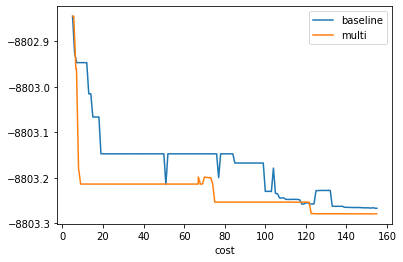

In [25]:
plt.plot(total_cost_1[np.sum(bo_1.initpts)-1:], fmin_1, label='baseline')
plt.plot(total_cost_2[np.sum(bo_2.initpts)-1:], fmin_2, label='multi')
plt.xlabel('cost')
plt.legend();

prior distributions were studied in sten 2021 http://urn.fi/URN:NBN:fi:aalto-202101311714

test optimisation with the recommended setup:

In [27]:
base_rate = 2/0.5**2

In [28]:
W_prior='gaussian'
W_mean = 0.9 * np.sqrt(2 / base_rate)
W_std = 0.5 / np.sqrt(base_rate)

In [29]:
bo_3 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    initpts=5,
    iterpts=1000,
    seed=seed,
    W_prior=W_prior,
    W_priorpar=[W_mean, W_std],
    maxcost=maxcost,
    acqcost=[cost_1, cost_0]
)

In [30]:
%time res_3 = bo_3.run()

CPU times: user 2h 55s, sys: 14min 3s, total: 2h 14min 58s
Wall time: 2h 3min 5s


In [31]:
[res_3.xbest, res_3.ybest]

[array([ 62.90923408,  50.08505891, 268.20649956, 177.56112177]),
 -8803.184477871653]

In [32]:
[res_3.xmin, res_3.fmin]

[array([252.93620581,  54.90496839,  50.08445558,  -1.65953318]),
 -8803.244459996338]

In [33]:
f_1(res_3.xmin)

array([[-8803.26592932]])

In [34]:
np.bincount(bo_3.model.inds)

array([151, 382])

compare:

In [35]:
estimated_mins_3 = [conv_res[2] for conv_res in res_3.convergence]
fmin_3 = f_1(np.array(estimated_mins_3))
total_cost_3 = np.cumsum((bo_3.model.inds==0)*cost_1 + (bo_3.model.inds==1)*cost_0)

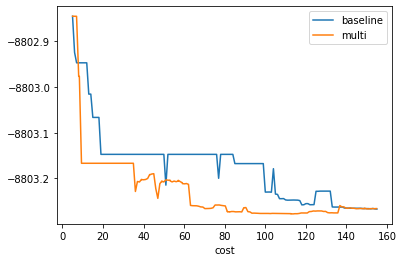

In [36]:
plt.plot(total_cost_1[np.sum(bo_1.initpts)-1:], fmin_1, label='baseline')
plt.plot(total_cost_3[np.sum(bo_3.initpts)-1:], fmin_3, label='multi')
plt.xlabel('cost')
plt.legend();